# Split the clean.csv file into multiple files. Compute VADER sentiment and score

In [1]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tnrange, tqdm_notebook, tqdm

# Define the currency
CURRENCY = "" #cardano, bitcoincash
CURRENCY_SYMBOL = "" #ADA, BCH
tweets_clean_file = 'data/twitter/%s/%s_tweets_clean.csv'%(CURRENCY_SYMBOL,CURRENCY)
path = 'data/twitter/%s'%(CURRENCY_SYMBOL) #/{CURRENCY}_tweets_clean.csv'


## Read the cleaned file

In [2]:
df_clean = pd.read_csv(tweets_clean_file,low_memory=False)
print(df_clean.shape)
df_clean.head(5)

(110217, 7)


,ID,Text,UserName,UserFollowerCount,RetweetCount,Likes,CreatedAt
0,1424255322978410502,RT : I'm giving away 500 $ADA worth ($700) to ...,Chris Naylor #CSC #XRP #ADA #XVG,48,283,0,Sun Aug 08 06:25:05 +0000 2021
1,1424255311309856776,Bitcoin Price Breaks $44k Level ! Massive BTC ...,COIN MINERS,2692,0,0,Sun Aug 08 06:25:02 +0000 2021
2,1424255285019938820,Crypto ETHADANew stars shining very soon.. It'...,Raul,49,0,0,Sun Aug 08 06:24:55 +0000 2021
3,1424255261154455554,Crypto ETHADANew stars shining very soon.. It'...,Raul,49,0,0,Sun Aug 08 06:24:50 +0000 2021
4,1424255257522049025,RT : Cardano $ADA just saw a 46% gain over 18 ...,Oscar Garcia,5888,13,0,Sun Aug 08 06:24:49 +0000 2021


# Exploratory Data Analysis

In [3]:
df_clean = df_clean.sort_values(by='ID') # the bigger the ID, the most recent the tweet 

Firstly, we will check the features present in our data and then we will look at their data types.

In [4]:
df_clean.columns

Index(['ID', 'Text', 'UserName', 'UserFollowerCount', 'RetweetCount', 'Likes',
       'CreatedAt'],
      dtype='object')

In [5]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110217 entries, 110216 to 0
Data columns (total 7 columns):
ID                   110217 non-null int64
Text                 110217 non-null object
UserName             110215 non-null object
UserFollowerCount    110217 non-null int64
RetweetCount         110217 non-null int64
Likes                110217 non-null int64
CreatedAt            110217 non-null object
dtypes: int64(4), object(3)
memory usage: 6.7+ MB


In [6]:
df_clean.describe()

,ID,UserFollowerCount,RetweetCount,Likes
count,1.102170e+05,1.102170e+05,110217.000000,110217.000000
mean,1.422829e+18,1.484355e+03,500.729080,2.497283
std,8.680134e+14,1.464951e+04,1050.463923,45.952969
min,1.421296e+18,0.000000e+00,0.000000,0.000000
25%,1.422033e+18,3.500000e+01,1.000000,0.000000
50%,1.422915e+18,1.290000e+02,20.000000,0.000000
75%,1.423588e+18,4.990000e+02,409.000000,0.000000
max,1.424255e+18,2.327132e+06,12084.000000,5823.000000


In [8]:
#print the dattypes for each variable
df_clean.dtypes

ID                    int64
Text                 object
UserName             object
UserFollowerCount     int64
RetweetCount          int64
Likes                 int64
CreatedAt            object
dtype: object

- **object**: Object format means variables are categorical. 
- **float64:** It represents the variable which have some decimal values involved. 
- **int64:** It represents the integer variables.

In [9]:
#check for NaN in entire dataframe

df_clean.isnull().values.any()

True

In [10]:
# count the NaN values

df_clean.isnull().sum().sum()

2

In [11]:
#drop the NaN value rowa
df_clean = df_clean.dropna()

In [12]:
#size of data frame after dropping the NaN values
df_clean.shape

(110215, 7)

## Sentiment analysis with Vader

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.

VADER takes into account 
- negations and contractions (not good, wasn’t good)
- Punctuation (good!!!), CAPS, emotes :), emojis 
- Intensificators (very, kind of), acronyms ‘lol’
- Scores between -1.0 (negative) and 1.0 (positive)

We will use this sentiment analysis of the tweets to calculate a score that will represent the importance of each tweet.

In [13]:
analyzer = SentimentIntensityAnalyzer()
compound = []
for i,s in enumerate(tqdm(df_clean['Text'])):
    vs = analyzer.polarity_scores(s)
    compound.append(vs["compound"])
df_clean["compound"] = compound
df_clean.head(2)

100%|████████████████████████████████████████████████████████████████████████| 110215/110215 [00:23<00:00, 4623.78it/s]


,ID,Text,UserName,UserFollowerCount,RetweetCount,Likes,CreatedAt,compound
110216,1421296095452450819,"I sold all NFTs coins, profit was pretty good....",Megalodon,156,0,4,Sat Jul 31 02:26:10 +0000 2021,0.945
110215,1421296095452450819,"I sold all NFTs coins, profit was pretty good....",Megalodon,156,0,4,Sat Jul 31 02:26:10 +0000 2021,0.945


## Calculate a score for each tweet

To calculate the score for each tweet, we use different variables to which we had a weight based on its importance.

The compound column represents the sentiment of the tweets and its value is between -1 and 1.

We also use the number of retweets, the number of likes, and the number of users that follow the tweet's author.

In [14]:
scores = []
for i, s in tqdm(df_clean.iterrows(), total=df_clean.shape[0]):
    scores.append(s["compound"] * ((int(s["UserFollowerCount"]))) * ((int(s["Likes"])+1)) *((int(s["RetweetCount"])+1)))
df_clean["score"] = scores
df_clean.head(2)

100%|████████████████████████████████████████████████████████████████████████| 110215/110215 [00:18<00:00, 5953.25it/s]


,ID,Text,UserName,UserFollowerCount,RetweetCount,Likes,CreatedAt,compound,score
110216,1421296095452450819,"I sold all NFTs coins, profit was pretty good....",Megalodon,156,0,4,Sat Jul 31 02:26:10 +0000 2021,0.945,737.1
110215,1421296095452450819,"I sold all NFTs coins, profit was pretty good....",Megalodon,156,0,4,Sat Jul 31 02:26:10 +0000 2021,0.945,737.1


## Split dataframe and save it into multiple files

In [15]:
from datetime import datetime

In [16]:
n = 20000  #chunk row size
chunks_df = [df_clean[i:i+n] for i in range(0,df_clean.shape[0],n)]

sep_char = '~'
for chunk_df in chunks_df:
    chunk_min = chunk_df['ID'].min()
    chunk_max = chunk_df['ID'].max()
    date_from = (datetime.strptime(chunk_df.iloc[0]['CreatedAt'], '%a %b %d %X %z %Y')).strftime('%Y-%m-%d %H-%M-%S')
    date_to = (datetime.strptime(chunk_df.iloc[-1]['CreatedAt'], '%a %b %d %X %z %Y')).strftime('%Y-%m-%d %H-%M-%S')
    print(date_from, date_to)

    # Write into csv
    chunk_df.to_csv(f"{path}/{date_from}{sep_char}{date_to}.csv", header=True, index=False)
    


2021-07-31 02-26-10 2021-08-01 11-09-24
2021-08-01 11-09-44 2021-08-03 08-12-58
2021-08-03 08-13-42 2021-08-04 21-42-50
2021-08-04 21-42-55 2021-08-06 06-32-49
2021-08-06 06-32-51 2021-08-07 12-09-40
2021-08-07 12-09-40 2021-08-08 06-25-05


# Visualizing the sentiment 

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

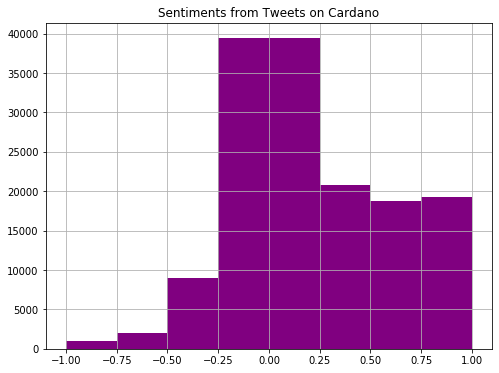

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram of the polarity values
df_clean['compound'].hist(bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")

plt.title("Sentiments from Tweets on Cardano")
plt.show()

To get a better visual of the polarit values, it can be helpful to remove the polarity values equal to zero and create a break in the histogram at zero.

In [19]:
# Remove polarity values equal to zero
sentiment_df = df_clean[df_clean.score != 0]

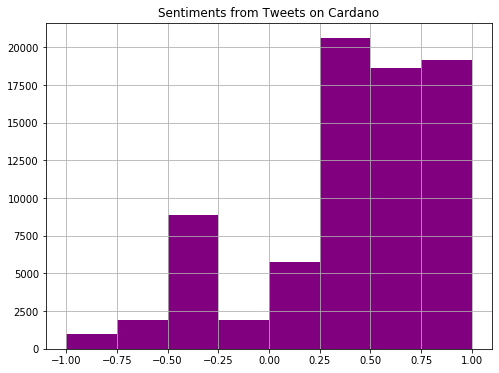

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram with break at zero
sentiment_df['compound'].hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")

plt.title("Sentiments from Tweets on Cardano")
plt.show()

This plot displays a revised histogram of compound values for tweets on dogecoin. For this histogram, compound values equal to zero have been removed, and a break has been added at zero, to better highlight the distribution of compound values.